Find Players with low potentials but high actual Rating
- Until 21 Rating under 80 and Potential under 80
- between 22 and 32 Rating over 85

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.crawler.fifa import extract_attributes


New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [2]:
FIFA = "2022"
sql_query = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

In [3]:
sql_diamants = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

sql_dishwasher = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
"""

sql_potentials = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = 2024
"""

In [4]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)


# Step 2: Write your SQL query
data_diamants = pd.DataFrame()
data_dishwasher = pd.DataFrame()

for FIFA in range(2011,2024):
    # Step 3: Use Pandas to execute the query and retrieve the data into a DataFrame
    df_diamants = pd.read_sql_query(sql_diamants.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)
    df_dishwasher = pd.read_sql_query(sql_dishwasher.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)

    df_diamants["FIFA"] = FIFA
    df_dishwasher["FIFA"] = FIFA


    data_diamants = pd.concat([df_diamants,data_diamants])
    data_dishwasher = pd.concat([df_dishwasher,data_dishwasher])

df_potentials_original = pd.read_sql_query(sql_potentials, conn)
# Step 4: Perform data manipulation or analysis using Pandas
# For example, you can display the first few rows of the DataFrame:
# Step 5: Close the database connection when you're done
conn.close()
data_diamants = data_diamants.reset_index()
data_dishwasher  = data_dishwasher.reset_index()

In [5]:
df_potentials = df_potentials_original.copy()

In [6]:
df = pd.merge(data_dishwasher, data_diamants, on=['ID', 'FIFA'], how='left')
df = df.set_index(['ID','Name','FIFA'],drop=True)
df_potentials = df_potentials.set_index(['ID','Name','FIFA'],drop=True)

In [7]:
df = df[['GK' not in i  for i in df.Position]]
df_potentials = df_potentials[['GK' not in i  for i in df_potentials.Position]]

In [8]:
df["target"] = ~df.PrimeName.isna()
# df["target"] = df['prime']
y = df["target"]

In [9]:
PLAYER_ATTRIBUTES = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking','Potential']

In [10]:
PLAYER_ATTRIBUTES = [ 'Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      ]

# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

###  Feature Engineering

#### Transform Defense Attributs

In [11]:

df['Defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
df_potentials['Defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)


# PLAYER_ATTRIBUTES.append('Defense')
df_processed = df[PLAYER_ATTRIBUTES]
df_potentials = df_potentials[PLAYER_ATTRIBUTES]

#### Transform Value

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.sport_analytics.model.eval import plot_correlation_heatmap


# Example usage:
# Assuming you have a DataFrame named 'my_df'
# plot_correlation_heatmap(df_processed)



In [13]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [14]:
df['target'].value_counts()

target
False    68709
True       183
Name: count, dtype: int64

In [15]:
import warnings
from sklearn.model_selection import train_test_split
# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

# Split the data into training and testing sets
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Now, you have X_train_scaled_df and X_test_scaled_df with the scaled data and the original index and columns.

X_train_scaled_df.head()



,,,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,FKAccuracy,LongPassing,BallControl,...,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
263381,J. Lemmerer,2022,-1.576773,-1.266205,0.964829,-0.066531,-1.046838,0.010772,-0.215253,-0.795758,-1.229576,-0.698438,...,-0.241991,1.084571,-0.923640,-1.156939,0.523645,-0.877621,-1.791308,0.403931,-0.258900,0.375208
240434,J. Tell,2022,1.409830,0.734436,1.093874,1.904788,0.520358,1.563854,0.421734,-0.083453,-0.244395,0.502823,...,0.625380,0.441394,-0.542974,0.205293,1.217410,0.153084,-0.983112,1.002311,-0.004283,1.532590
198934,Bergson,2014,0.414296,-0.188937,0.706740,1.153809,-0.165290,1.486200,0.819850,0.549707,-0.654887,0.703033,...,0.940788,1.268336,-0.923640,-0.355626,1.425540,0.079462,-0.579014,1.151906,-0.343773,0.553267
248342,T. Heggem,2020,-0.581239,-1.727891,-1.551537,-0.160404,-2.711984,-1.619964,-2.205837,-1.428919,-2.214757,-2.300120,...,-1.109363,0.900806,-0.828473,0.125161,-1.488273,-0.288647,0.517823,-1.690400,-1.786607,-1.227321
199050,Vinicius,2011,-1.079006,-0.958414,-1.228926,-1.568489,-1.634536,-1.542310,-0.135630,0.707997,-0.490690,-0.698438,...,0.152269,0.073864,-0.067141,0.686080,-0.863885,0.889301,0.748736,-0.568437,0.165462,-0.604115


In [16]:
import shap

In [17]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    # 'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    # 'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    # # 'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    # 'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    try:
        # Interpret the model using SHAP values
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test_scaled_df)
        # Save SHAP values to a pickle file
        with open(f"{model_name}_shap_values.pkl", "wb") as file:
            pickle.dump(shap_values, file)
    except:
        print("Fehler bei SHAP",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


LightGBM Classifier training----->
[LightGBM] [Info] Number of positive: 147, number of negative: 54966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 55113, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002667 -> initscore=-5.924038
[LightGBM] [Info] Start training from score -5.924038
Model: LightGBM Classifier
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     13743
        True       0.43      0.08      0.14        36

    accuracy                           1.00     13779
   macro avg       0.71      0.54      0.57     13779
weighted avg       1.00      1.00      1.00     13779

Confusion Matrix:
[[13739     4]
 [   33     3]]
AUC: 0.90
Precision: 0.43



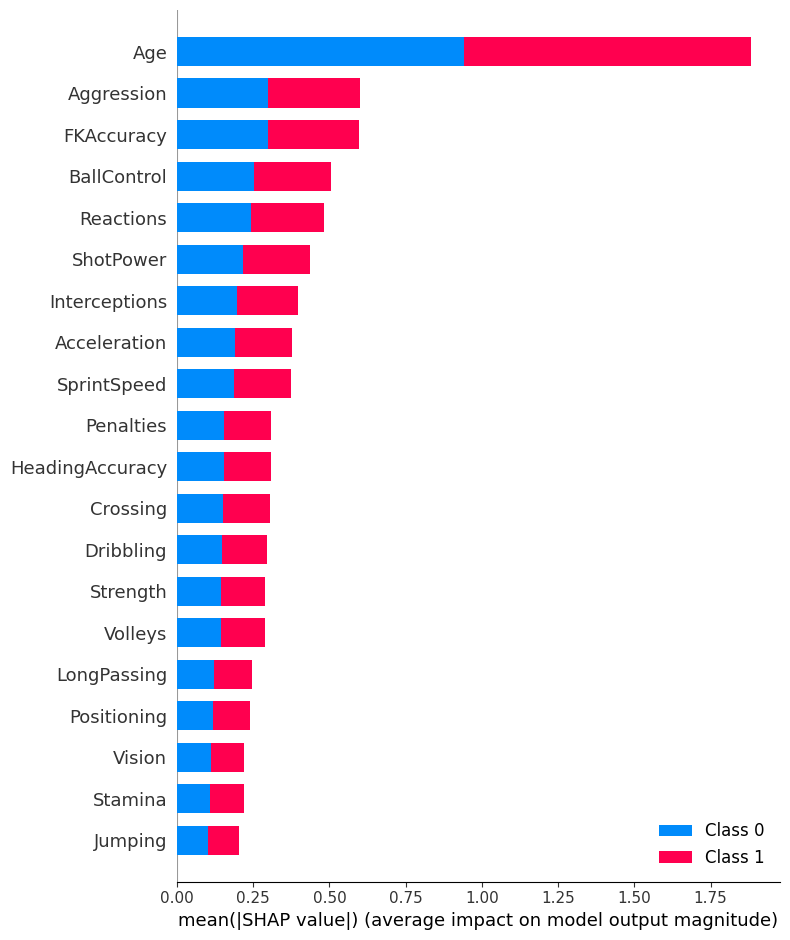

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values, X_test_scaled_df)

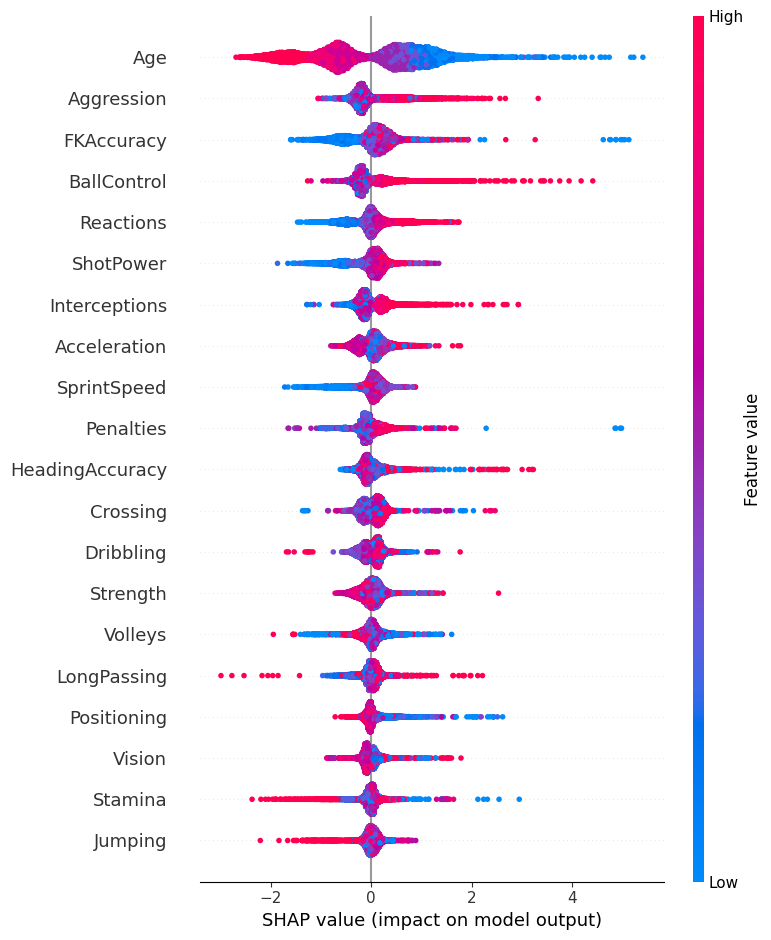

In [19]:
shap.summary_plot(shap_values[1], X_test_scaled_df)

In [20]:
shap.summary_plot

<function shap.plots._beeswarm.summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x00000259D901CE10>, show_values_in_legend=False, auto_size_plot=None, use_log_scale=False)>

In [21]:
X_test.iloc[0, :]

Age                20.0
Crossing           44.0
Finishing          37.0
HeadingAccuracy    41.0
ShortPassing       48.0
Volleys            29.0
Dribbling          51.0
FKAccuracy         32.0
LongPassing        45.0
BallControl        50.0
Acceleration       67.0
SprintSpeed        66.0
Agility            58.0
Reactions          47.0
Balance            68.0
ShotPower          41.0
Jumping            57.0
Stamina            48.0
Strength           56.0
LongShots          40.0
Aggression         35.0
Interceptions      48.0
Positioning        46.0
Vision             48.0
Penalties          43.0
Name: (264332, S. Al Toiawy, 2023), dtype: float64

In [22]:
explainer.expected_value

[11.088102985083223, -11.088102985083223]

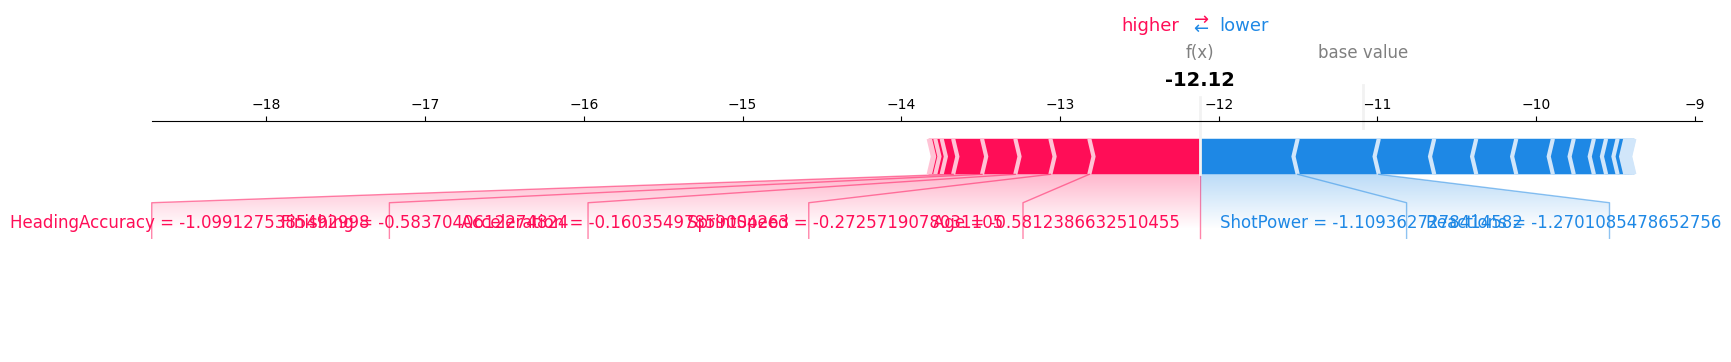

In [23]:
shap.plots.force(explainer.expected_value[1], shap_values[1][0,:], X_test_scaled_df.iloc[0, :], matplotlib = True)

In [24]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

RuntimeError: Plotting 13779 observations may be slow. Consider subsampling or set ignore_warnings=True to ignore this message.

In [ ]:
model.predict_proba(X_test)[:,1]>0.3

In [ ]:
from sklearn.metrics import precision_score
y_score = model.predict_proba(X_test)[:,1]>0.05
pre = np.round(precision_score(y_pred=y_score,y_true=y_test),3)
print("Potentials:",sum(y_score),"Precision:",pre,"------> Correct Potentials",pre*sum(y_score))
X_test[y_score&y_test]


In [ ]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance

# Example usage:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, 'LightGBM Classifier')
if False:
    my_model = model_results['Random Forest Classifier']['Model']
    features = plot_feature_importance(my_model, 'Random Forest Classifier')
    


    my_model = model_results['XGBoost Classifier']['Model']
    features = plot_feature_importance(my_model, 'XGBoost Classifier')

### evaluate test data

In [ ]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [ ]:
import pickle

try:
    # Interpret the model using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # Save SHAP values to a pickle file
    with open(f"{model_name}_shap_values.pkl", "wb") as file:
        pickle.dump(shap_values, file)
except:
    print("Fehler bei SHAP",model_name)

In [ ]:
import tqdm
df_shap = pd.DataFrame()
i = 0
for i in range(len(shap_values.values)):
    df_shap[i] = shap_values.values[i][:,1]

df_shap = df_shap.T

In [ ]:
my_model = model_results[ 'LightGBM Classifier']['Model']
y_pred = pd.DataFrame(my_model.predict_proba(X_test)[:,1],columns=["prediction"],index=y_test.index)

In [ ]:
df_shap.index = X_test.index
df_shap.columns = X_test.columns
df_shap["SHAP"] = df_shap.T.sum().values

df_merge = pd.concat([y_pred,df_shap],axis=1)
df_merge = pd.concat([df['Overall'],df_merge],axis=1,join='inner')


In [ ]:
df_merge = df_merge.sort_values(by="Aggression",ascending=False).round(3)
df_merge.head(10)

In [ ]:
X_test[X_test.index == df_merge.index[0]]

In [ ]:
df_shap.sum()/(-df_shap['SHAP'].sum())

### predict potentials

In [ ]:
prospects = pd.DataFrame(my_model.predict_proba(df_potentials)[:,1],columns=["prediction"],index=df_potentials.index)
# TODO: SHAP VALUES FOR
df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = False).head(10)

In [ ]:
prospects.sort_values('prediction',ascending=False).round(3).head(50)